# Disciplines

In [1]:
from gemseo_oad_training.models import aerodynamic
from gemseo_oad_training.models import approach
from gemseo_oad_training.models import battery
from gemseo_oad_training.models import climb
from gemseo_oad_training.models import engine
from gemseo_oad_training.models import fuel_tank
from gemseo_oad_training.models import geometry
from gemseo_oad_training.models import mass
from gemseo_oad_training.models import mission
from gemseo_oad_training.models import operating_cost
from gemseo_oad_training.models import take_off
from gemseo_oad_training.models import total_mass

In [2]:
from gemseo.disciplines.auto_py import AutoPyDiscipline
discipline_aerodynamic = AutoPyDiscipline(aerodynamic)
discipline_approach = AutoPyDiscipline(approach)
discipline_battery = AutoPyDiscipline(battery)
discipline_climb = AutoPyDiscipline(climb)
discipline_engine = AutoPyDiscipline(engine)
discipline_fuel_tank = AutoPyDiscipline(fuel_tank)
discipline_geometry = AutoPyDiscipline(geometry)
discipline_mass = AutoPyDiscipline(mass)
discipline_mission = AutoPyDiscipline(mission)
discipline_operating_cost = AutoPyDiscipline(operating_cost)
discipline_take_off = AutoPyDiscipline(take_off)
discipline_total_mass = AutoPyDiscipline(total_mass)


In [3]:
disciplines = [discipline_aerodynamic,discipline_approach,discipline_battery,discipline_climb,discipline_engine,
               discipline_fuel_tank,discipline_geometry,discipline_mass,discipline_mission,discipline_operating_cost,
               discipline_take_off,discipline_total_mass]

# Design space

In [4]:
from gemseo import configure_logger
configure_logger()

<RootLogger root (INFO)>

In [5]:
from gemseo_oad_training.unit import convert_from
from gemseo.algos.parameter_space import ParameterSpace
from utils import update_default_inputs

x_def={'slst':convert_from('kN',150),'n_pax':150.0,'area':180.0,'ar':9.0,'fuel_type':'liquid_h2','engine_type':'turbofan','design_range':5500000}
update_default_inputs(disciplines,x_def)

uncertain_space = ParameterSpace()
uncertain_space.add_random_variable("gi","OTTriangularDistribution", minimum=0.35, mode=0.4, maximum=0.405)
uncertain_space.add_random_variable("vi","OTTriangularDistribution", minimum=0.755, mode=0.800, maximum=0.805)
uncertain_space.add_random_variable("aef","OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)
uncertain_space.add_random_variable("cef","OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)
uncertain_space.add_random_variable("sef","OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)

In [6]:
from gemseo import sample_disciplines
from gemseo.disciplines.surrogate import SurrogateDiscipline

training_dataset = sample_disciplines(disciplines, uncertain_space, ["tofl", "vapp","vz","span","length","fm","mtom"], algo_name="OT_MONTE_CARLO", n_samples=100)

    INFO - 16:48:23: *** Start Sampling execution ***
    INFO - 16:48:23: Sampling
    INFO - 16:48:23:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 16:48:23:    MDO formulation: MDF
    INFO - 16:48:23: Running the algorithm OT_MONTE_CARLO:
    INFO - 16:48:23:      9%|▉         | 9/100 [00:00<00:02, 43.93 it/sec]

    INFO - 16:48:25:    100%|██████████| 100/100 [00:01<00:00, 52.55 it/sec]
    INFO - 16:48:25: *** End Sampling execution (time: 0:00:01.925119) ***


In [7]:
import matplotlib.pyplot as plt
import pprint

In [8]:
surrogate_discipline = SurrogateDiscipline("RBFRegressor", training_dataset)

In [9]:
rmse = surrogate_discipline.get_error_measure("RMSEMeasure")
rmse.compute_learning_measure(as_dict=True)

{'fm': array([5.31946668e-17]),
 'length': array([0.]),
 'mtom': array([9.54232895e-12]),
 'span': array([0.]),
 'tofl': array([3.21554936e-14]),
 'vapp': array([4.14314051e-15]),
 'vz': array([6.02391913e-16])}

In [10]:
rmse.compute_cross_validation_measure(as_dict=True)

{'fm': array([0.00112625]),
 'length': array([0.]),
 'mtom': array([40.4143973]),
 'span': array([0.]),
 'tofl': array([1.15736785]),
 'vapp': array([0.01659547]),
 'vz': array([0.00990716])}

In [11]:
from gemseo.uncertainty.statistics.empirical_statistics import EmpiricalStatistics

In [12]:
statistics = EmpiricalStatistics(training_dataset)
mean = statistics.compute_mean()
mean

{'aef': array([1.00852155]),
 'cef': array([1.00566636]),
 'fm': array([0.10036764]),
 'gi': array([0.38656094]),
 'length': array([39.75]),
 'mtom': array([76422.68379674]),
 'sef': array([1.00613398]),
 'span': array([40.24922359]),
 'tofl': array([1165.70681043]),
 'vapp': array([60.78523905]),
 'vi': array([0.78770926]),
 'vz': array([6.78386844])}

In [13]:
variance = statistics.compute_variance()
variance

{'aef': array([6.81645596e-05]),
 'cef': array([6.36776767e-05]),
 'fm': array([0.00038875]),
 'gi': array([0.00015218]),
 'length': array([0.]),
 'mtom': array([377120.26809291]),
 'sef': array([6.78384882e-05]),
 'span': array([5.04870979e-29]),
 'tofl': array([295.76320574]),
 'vapp': array([0.06259838]),
 'vi': array([0.00013086]),
 'vz': array([0.02887258])}

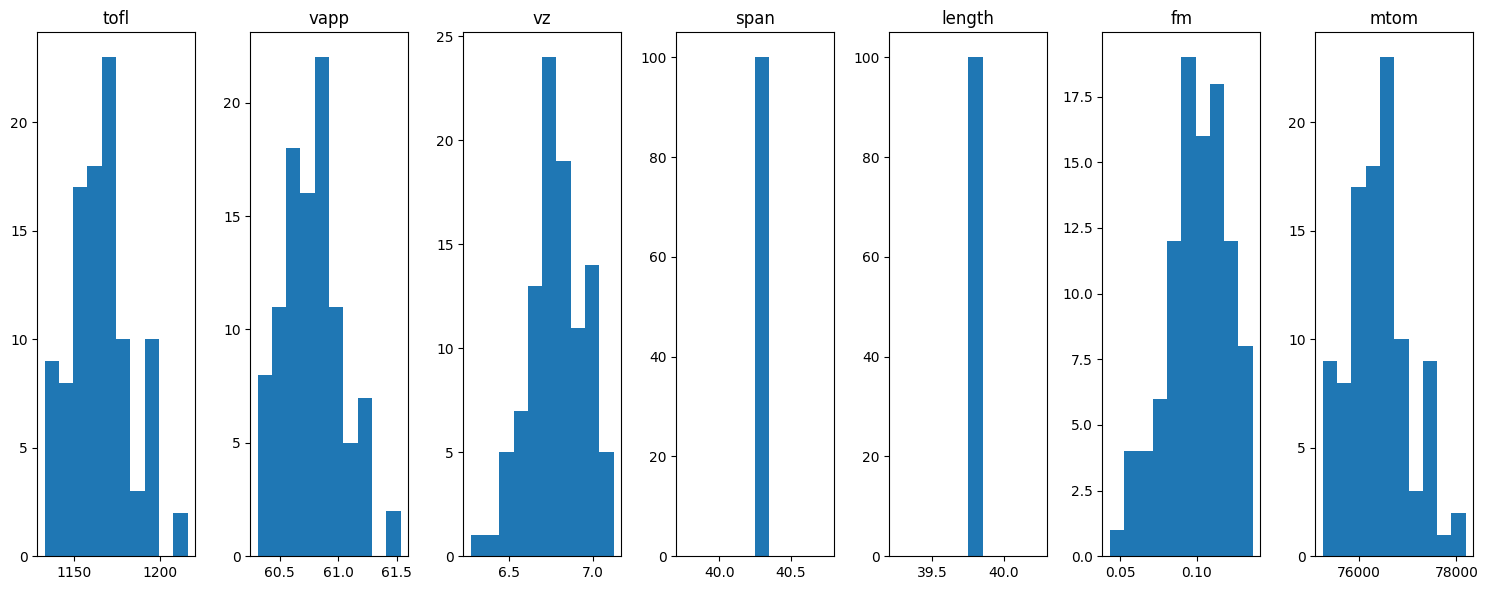

In [14]:
fig, axes = plt.subplots(1, 7,figsize=(15,6))
for ax, name in zip(axes, ["tofl", "vapp","vz","span","length","fm","mtom"]):
    ax.hist(training_dataset.get_view(variable_names=name))
    ax.set_title(name)
plt.tight_layout()
plt.show()

In [15]:
from gemseo.uncertainty.sensitivity.sobol_analysis import SobolAnalysis


In [16]:
sobol = SobolAnalysis()
sobol.compute_samples([surrogate_discipline], uncertain_space, 100)

 WARNING - 16:48:28: No coupling in MDA, switching chain_linearize to True.
    INFO - 16:48:28: *** Start SobolAnalysisSamplingPhase execution ***
    INFO - 16:48:28: SobolAnalysisSamplingPhase
    INFO - 16:48:28:    Disciplines: RBF_Sampling
    INFO - 16:48:28:    MDO formulation: MDF
    INFO - 16:48:28: Running the algorithm OT_SOBOL_INDICES:
    INFO - 16:48:29:    100%|██████████| 96/96 [00:01<00:00, 56.03 it/sec]
    INFO - 16:48:29: *** End SobolAnalysisSamplingPhase execution (time: 0:00:01.741332) ***


GROUP        inputs                                           outputs         \
VARIABLE         gi        vi       aef       cef       sef        fm length   
COMPONENT         0         0         0         0         0         0      0   
0          0.394131  0.779313  1.028623  1.018127  1.006415  0.066153  39.75   
1          0.366964  0.764723  1.014139  0.994315  0.994671  0.078727  39.75   
2          0.394951  0.799486  1.009626  1.024286  1.003858  0.096396  39.75   
3          0.375284  0.796036  1.013230  0.997688  1.001509  0.117977  39.75   
4          0.375179  0.799914  1.017345  0.996241  1.006883  0.122603  39.75   
..              ...       ...       ...       ...       ...       ...    ...   
91         0.365560  0.778220  1.020575  1.009792  1.001509  0.077135  39.75   
92         0.398343  0.776086  1.007875  1.003573  1.006883  0.086363  39.75   
93         0.387046  0.772072  1.007799  1.001951  1.003720  0.082613  39.75   
94         0.400720  0.781155  1.002871  0.993853  1.014974  0.106708  39.75   
95         0.394662  0.778199  0.997953  1.006463  1.010079  0.091583  39.75   

GROUP                                                                 
VARIABLE           mtom       span         tofl       vapp        vz  
COMPONENT             0          0            0          0         0  
0          76174.466799  40.249224  1158.724829  60.640702  6.722897  
1          76487.712444  40.249224  1167.518261  60.827566  6.733060  
2          76253.704911  40.249224  1160.943240  60.680140  6.821627  
3          76732.273077  40.249224  1174.315347  60.923181  6.672204  
4          76998.304802  40.249224  1181.807020  61.030110  6.578164  
..                  ...        ...          ...        ...       ...  
91         76982.844405  40.249224  1181.364690  60.994689  6.564363  
92         75875.142954  40.249224  1150.387146  60.566590  6.929986  
93         76097.608363  40.249224  1156.564534  60.661108  6.871996  
94         76113.859494  40.249224  1157.032461  60.687451  6.897615  
95         76138.476483  40.249224  1157.708789  60.678477  6.924978  

[96 rows x 12 columns]

In [17]:
sobol.compute_indices(output_names=["tofl", "vapp","vz","fm","mtom"])

SobolAnalysis.SensitivityIndices(first={'tofl': [{'gi': array([1.64839613]), 'vi': array([0.22907019]), 'aef': array([0.36245365]), 'cef': array([0.25319961]), 'sef': array([1.26487027])}], 'vapp': [{'gi': array([1.33507689]), 'vi': array([0.17803353]), 'aef': array([0.17920892]), 'cef': array([0.15685187]), 'sef': array([1.11273084])}], 'vz': [{'gi': array([1.50395075]), 'vi': array([-0.0504117]), 'aef': array([1.17631996]), 'cef': array([0.13520243]), 'sef': array([0.72984287])}], 'fm': [{'gi': array([-0.2992196]), 'vi': array([0.32261898]), 'aef': array([-0.18928587]), 'cef': array([-0.07490228]), 'sef': array([-0.31056745])}], 'mtom': [{'gi': array([1.64846973]), 'vi': array([0.22977299]), 'aef': array([0.36210066]), 'cef': array([0.25302895]), 'sef': array([1.27184392])}]}, second={'tofl': [{'gi': {'gi': array([[0.]]), 'vi': array([[-0.37643432]]), 'aef': array([[-0.82076223]]), 'cef': array([[-0.7342903]]), 'sef': array([[0.75190593]])}, 'vi': {'gi': array([[-0.37643432]]), 'vi':

In [18]:
pprint.pprint(sobol.indices.first)
pprint.pprint(sobol.indices.total)

{'fm': [{'aef': array([-0.18928587]),
         'cef': array([-0.07490228]),
         'gi': array([-0.2992196]),
         'sef': array([-0.31056745]),
         'vi': array([0.32261898])}],
 'mtom': [{'aef': array([0.36210066]),
           'cef': array([0.25302895]),
           'gi': array([1.64846973]),
           'sef': array([1.27184392]),
           'vi': array([0.22977299])}],
 'tofl': [{'aef': array([0.36245365]),
           'cef': array([0.25319961]),
           'gi': array([1.64839613]),
           'sef': array([1.26487027]),
           'vi': array([0.22907019])}],
 'vapp': [{'aef': array([0.17920892]),
           'cef': array([0.15685187]),
           'gi': array([1.33507689]),
           'sef': array([1.11273084]),
           'vi': array([0.17803353])}],
 'vz': [{'aef': array([1.17631996]),
         'cef': array([0.13520243]),
         'gi': array([1.50395075]),
         'sef': array([0.72984287]),
         'vi': array([-0.0504117])}]}
{'fm': [{'aef': array([0.17039737]),
     

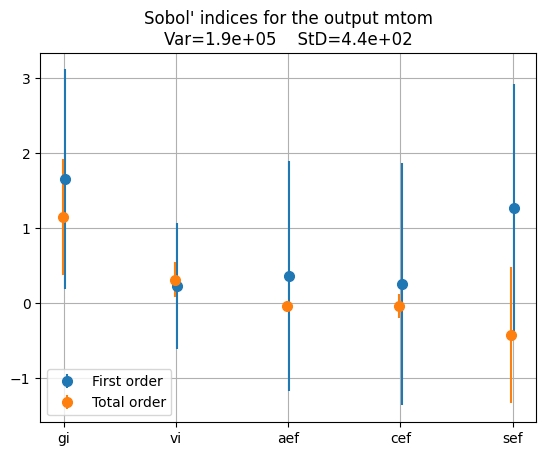

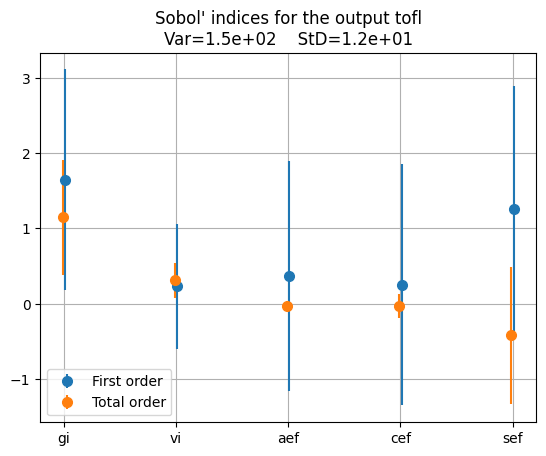

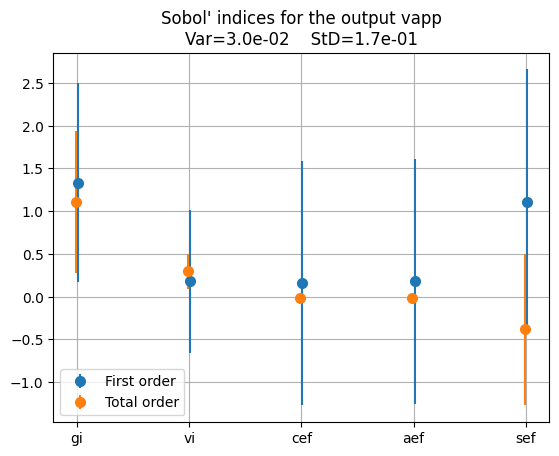

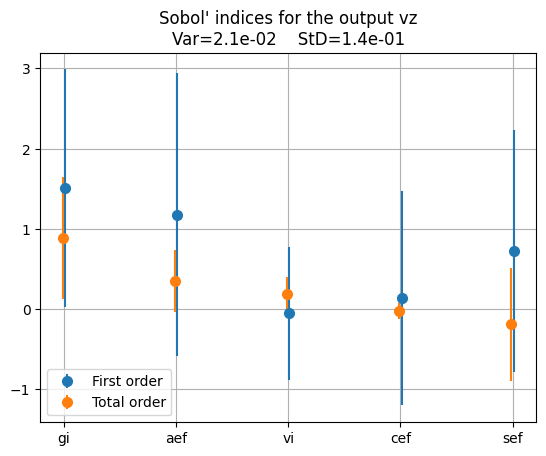

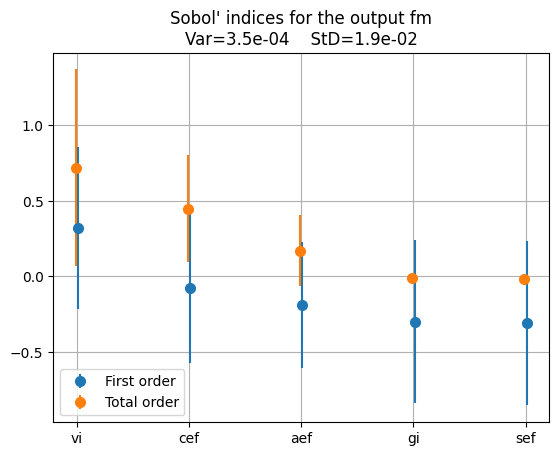

In [19]:
plt.show(sobol.plot("mtom", save=False, show=True))
plt.show(sobol.plot("tofl", save=False, show=True))
plt.show(sobol.plot("vapp", save=False, show=True))
plt.show(sobol.plot("vz", save=False, show=True))
plt.show(sobol.plot("fm", save=False, show=True))